#Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,SimpleRNN,Dense,Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from pandas import DataFrame
from pandas import concat
import keras

keras.utils.set_random_seed(1234)







#Uploading csv Dataset files


# ***Beijing_outlier_removed.csv*** dataset should be uploaded using the following code

In [2]:
from google.colab import files

def upload_files():
    # initiates the upload - follow the dialogues that appear
    uploaded = files.upload()

    # verify the upload
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

    # uploaded files need to be written to file to interact with them
    # as part of a file system
    for filename in uploaded.keys():
        with open(filename, 'wb') as f:
            f.write(uploaded[filename])

upload_files()



Saving Beijing_outlier_removed.csv to Beijing_outlier_removed.csv
User uploaded file "Beijing_outlier_removed.csv" with length 6783690 bytes


#Reading the csv files as pandas dataset


In [ ]:

# Link to download Beijing_outlier_removed https://drive.google.com/file/d/1nly907OHVHSS60lurWyVlAZ2WDEeJaRu/view?usp=sharing

df = pd.read_csv("Beijing_outlier_removed.csv")
df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,sin_dir,cos_dir,wind_direction,wind_direction_degrees,AQHI
0,6.833333,9.833333,5.333333,13.111111,308.333333,75.750000,-1.216667,1023.191667,-19.916667,0.0,3.875000,-0.249528,0.717289,-0.334782,-19.181605,3.129724
1,6.000000,9.250000,5.833333,12.400000,283.333333,75.333333,-1.891667,1024.208333,-21.833333,0.0,3.366667,-0.346071,0.775598,-0.419688,-24.046378,3.059368
2,4.833333,6.916667,6.750000,14.000000,308.333333,66.333333,-2.283333,1024.866667,-21.625000,0.0,2.716667,-0.340467,0.847333,-0.382066,-21.890749,2.827127
3,5.500000,6.583333,7.666667,13.545455,333.333333,70.583333,-2.766667,1025.275000,-20.941667,0.0,2.575000,-0.130189,0.800005,-0.161321,-9.242987,2.954489
4,5.333333,7.333333,10.916667,18.454545,383.333333,68.333333,-3.266667,1026.058333,-20.108333,0.0,1.950000,-0.054071,0.761423,-0.070894,-4.061901,3.121171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26742,16.083333,38.416667,3.583333,28.818182,408.333333,71.900000,12.000000,1011.950000,-15.133333,0.0,2.141667,-0.481986,0.699747,-0.603170,-34.559112,4.035945
26743,19.000000,38.166667,5.083333,41.666667,533.333333,56.545455,10.933333,1012.141667,-14.191667,0.0,1.275000,-0.688671,0.366979,-1.081192,-61.947727,4.282490
26744,15.666667,33.083333,5.000000,40.833333,558.333333,54.000000,10.041667,1012.625000,-13.558333,0.0,1.350000,-0.235702,0.686887,-0.330556,-18.939440,4.071514
26745,13.666667,29.666667,5.500000,40.166667,591.666667,53.250000,9.225000,1012.841667,-13.166667,0.0,1.466667,-0.218377,0.779487,-0.273152,-15.650469,3.960568


#The following cell contains all the functions requred to train a RNN model with the best set of Hyperparameters

In [7]:
def missing_value_handler(dataset):
     interpolated_dataset = dataset.interpolate()
     interpolated_dataset = interpolated_dataset.apply(pd.to_numeric, errors='coerce')

     return(interpolated_dataset)

#########################################

def dataset_scaling(dataset):

    values = dataset.values
    values = values.astype('float32')
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    return(scaled)

##################################

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
  names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
  if i == 0:
   names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
  else:
   names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
  agg.dropna(inplace=True)
 return agg




##########################################

def rnn_trainer(dataset,df,n,rnn_units,dense_units,air_property,name,name1,epochs = 100,batch_size = 32,learning_rate = 0.001):


   dict = {"AQHI":-1,"PM2.5":-16,"PM10":-15,"SO2":-14,"NO2":-13,"CO":-12,"O3":-11}

   # split into train sets、validation sets and test sets
   values = dataset.values
   number=len(values)
   n_train_hours = int(number*0.7)
   n_valid_hours = int(number*0.9)
   train = values[:n_train_hours, :]
   valid = values[n_train_hours:n_valid_hours, :]
   test = values[n_valid_hours:, :]
   # split into input and outputs
   u = 16*n
   train_X, train_y = train[:, :-u], train[:, dict[air_property]]
   valid_X, valid_y = valid[:, :-u], valid[:, dict[air_property]]
   test_X, test_y = test[:, :-u], test[:, dict[air_property]]
   # reshape input to be 3D [samples, timesteps, features]
   train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
   valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
   test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))





   timesteps = train_X.shape[1]
   input_dim = train_X.shape[2]
   output_dim=1



   inputs = keras.Input(shape=(timesteps, input_dim))

   tf.random.set_seed(1234)

   rnn_out = SimpleRNN(rnn_units, activation='relu', return_sequences=False)(inputs)


   dense = Dense(units=dense_units, activation='relu')(rnn_out)

   output = Dense(units=output_dim, activation='linear')(dense)


   rnn_1 = keras.Model(inputs=inputs,  outputs=output)


   rnn_1.compile(loss='mse', optimizer=keras.optimizers.Adam(
       learning_rate=learning_rate), metrics=['mae'])

   callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10,restore_best_weights=True)


   history = rnn_1.fit(train_X, train_y, epochs=epochs, batch_size=batch_size,callbacks=[callback], validation_data=(valid_X, valid_y)

                    )
   visualize_loss(history, "Training and Validation Loss",name1)

   errors = evaluate(rnn_1,df,test_X,test_y,air_property,name)

   return(rnn_1,errors)



############################################################



def dataset_pipeline_rnn(dataset,used_timesteps,prediction_time,rnn_units,dense_units,air_property,name = 'time_series.png',name1="loss",epochs = 100,batch_size = 32,learning_rate = 0.001):

     interpolated_dataset = missing_value_handler(dataset)
     scaled_dataset = dataset_scaling(interpolated_dataset)
     series_dataset = series_to_supervised(scaled_dataset, used_timesteps, prediction_time)
     rnn_1 = rnn_trainer(series_dataset,interpolated_dataset,prediction_time,rnn_units,dense_units,air_property,name,name1,epochs,batch_size,learning_rate)

     return(rnn_1)




###############################################

def visualize_loss(history, title,name):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(dpi=300)
    plt.plot(epochs, loss,"black", label="Training loss")
    plt.plot(epochs,loss, 'o', markersize = 5,color="black")
    plt.plot(epochs, val_loss,color="gray", label="Validation loss")
    plt.plot(epochs,val_loss, 'o', markersize = 5,color="gray")
    plt.title(name)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    #plt.savefig(name)
    plt.show()
    plt.close()

########################################

def compare_visual(data1, data2,air_property,name='time_series.png'):
    fig, axes = plt.subplots(
        nrows=1, ncols=1, figsize=(20, 15), dpi=300, facecolor="w", edgecolor="k"
    )


    ax = data1[air_property].plot(
            ax=axes,
            color='black',
            rot=25,
            label="actual",
            lw = 4
    )
    ax = data2[air_property].plot(
            ax=axes,
            color='gray',
            rot=25,
            label='prediction',
            lw = 4
    )
    ax.legend(fontsize = 28)

    ax.set_xlabel("Hour",fontsize = 28)
    ax.set_ylabel(air_property,fontsize = 28)
    ax.set_title(name,fontsize = 28)
    ax.tick_params(axis='both', labelsize=28)
    plt.tight_layout()
    #plt.savefig(name)
    plt.show()
    plt.close()



######################################################



def evaluate(model,dataset,test_X,test_y,air_property,name):

    dict = {"AQHI":-1,"PM2.5":-16,"PM10":-15,"SO2":-14,"NO2":-13,"CO":-12,"O3":-11}
    yhat = model.predict(test_X)

    inv_yhat=inv_scale(dataset,yhat,air_property)
    inv_y=inv_scale(dataset,test_y,air_property)


    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    mae = mean_absolute_error(inv_y, inv_yhat)
    print('Test MAE: %.3f' % mae)
    R2=r2_score(inv_y, inv_yhat)
    print('Test R2: %.3f' % R2)

    y1 = DataFrame(
         inv_y[-100:], index=dataset.index[-100:], columns=[dataset.columns[dict[air_property]]])
    y2 = DataFrame(
          inv_yhat[-100:], index=dataset.index[-100:], columns=[dataset.columns[dict[air_property]]])
    compare_visual(y1,y2,air_property,name)
    return(rmse,mae,R2)

################################################

def inv_scale(df, y,air_property):

    dict = {"AQHI":-1,"PM2.5":-16,"PM10":-15,"SO2":-14,"NO2":-13,"CO":-12,"O3":-11}
    max = df.max()[dict[air_property]]
    min = df.min()[dict[air_property]]

    yy=y.copy()
    for i in range(len(yy)):
        yy[i] = yy[i]*(max-min)+min
    return yy


##############################################











#RNN

Epoch 1/100
585/585 [==============================] - 6s 5ms/step - loss: 0.0058 - mae: 0.0469 - val_loss: 0.0017 - val_mae: 0.0276
Epoch 2/100
585/585 [==============================] - 2s 3ms/step - loss: 0.0020 - mae: 0.0295 - val_loss: 0.0018 - val_mae: 0.0310
Epoch 3/100
585/585 [==============================] - 2s 3ms/step - loss: 0.0019 - mae: 0.0285 - val_loss: 0.0014 - val_mae: 0.0252
Epoch 4/100
585/585 [==============================] - 2s 4ms/step - loss: 0.0019 - mae: 0.0277 - val_loss: 0.0016 - val_mae: 0.0280
Epoch 5/100
585/585 [==============================] - 2s 4ms/step - loss: 0.0018 - mae: 0.0268 - val_loss: 0.0015 - val_mae: 0.0257
Epoch 6/100
585/585 [==============================] - 2s 3ms/step - loss: 0.0017 - mae: 0.0257 - val_loss: 0.0013 - val_mae: 0.0235
Epoch 7/100
585/585 [==============================] - 2s 3ms/step - loss: 0.0017 - mae: 0.0257 - val_loss: 0.0013 - val_mae: 0.0236
Epoch 8/100
585/585 [==============================] - 2s 4ms/step - 

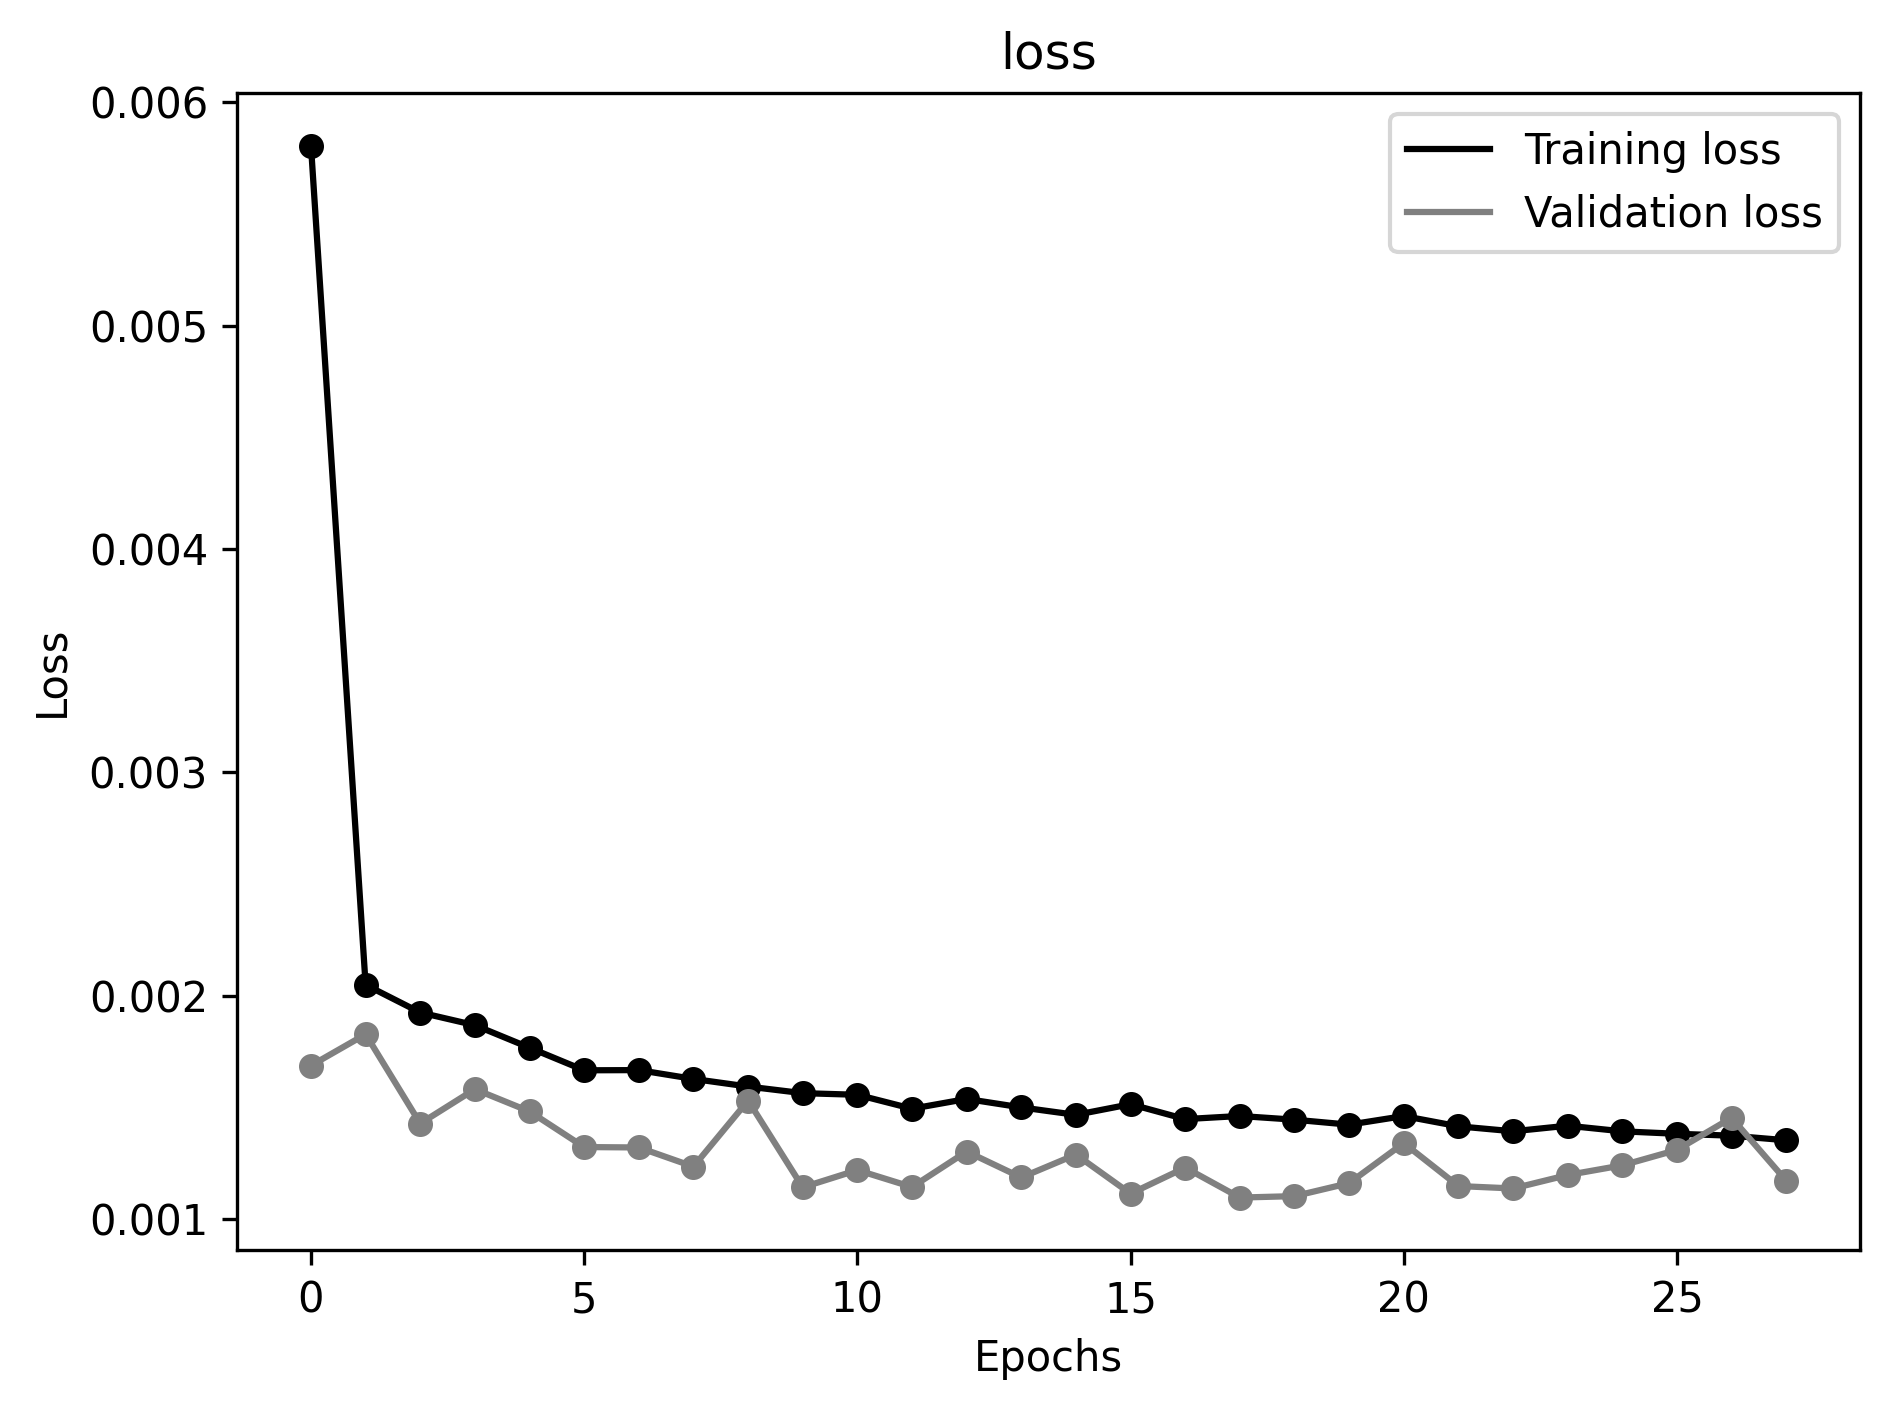

84/84 [==============================] - 0s 2ms/step
Test RMSE: 0.553
Test MAE: 0.315
Test R2: 0.943


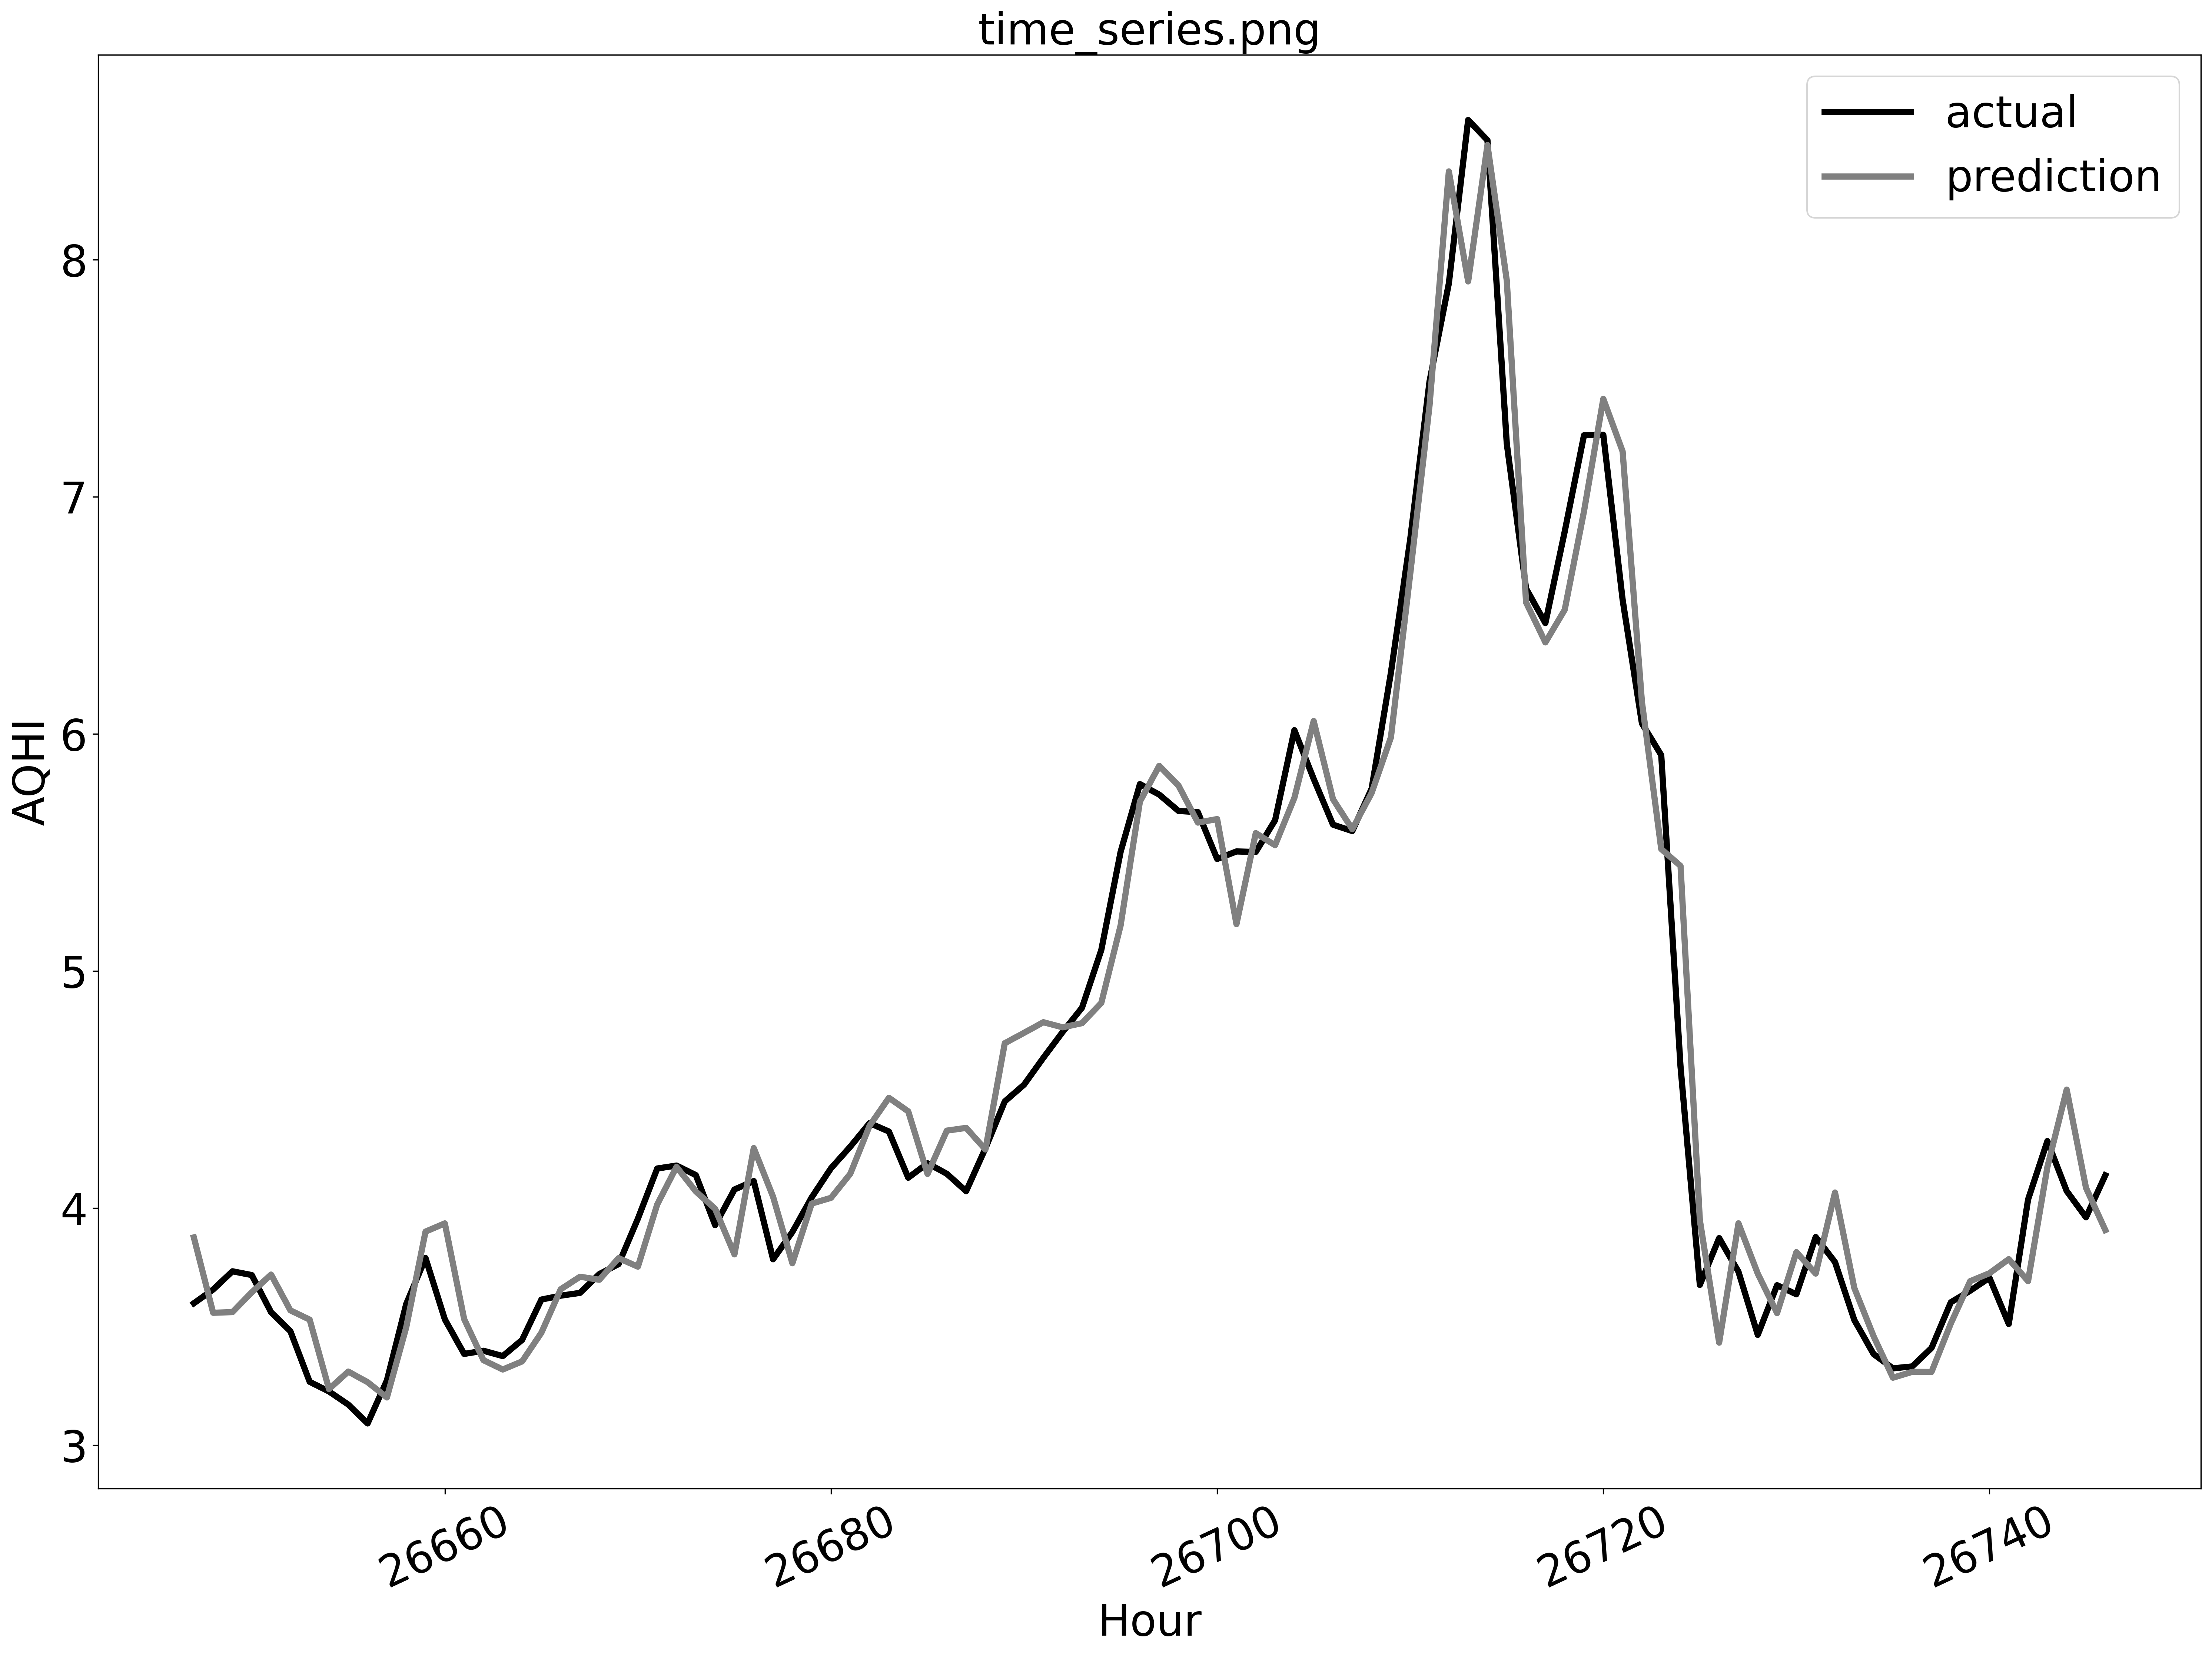

In [9]:
RNN = dataset_pipeline_rnn(df,3,1,64,128,'AQHI',name = 'time_series.png',name1="loss",epochs = 100,batch_size = 32,learning_rate = 0.001)


In [11]:
RNN

(<keras.src.engine.functional.Functional at 0x791f148eed10>,
 (0.5532385, 0.3148066, 0.9434095342437159))

In [12]:
RNN[0].weights

[<tf.Variable 'simple_rnn_2/simple_rnn_cell/kernel:0' shape=(48, 64) dtype=float32, numpy=
 array([[ 0.30391893,  0.19411579, -0.02288414, ..., -0.02147448,
          0.1557133 , -0.11804736],
        [-0.21041399, -0.15572114,  0.02912952, ...,  0.03924929,
         -0.24881387,  0.12360857],
        [ 0.00086393,  0.1809046 , -0.23936954, ..., -0.07866409,
         -0.05757409, -0.00689971],
        ...,
        [ 0.19556981, -0.22609453, -0.06580894, ..., -0.06333522,
          0.04180565, -0.0439126 ],
        [ 0.00098824,  0.1705586 , -0.0348183 , ..., -0.02226424,
         -0.13003449,  0.00684518],
        [-0.36872795,  0.16144165, -0.11131876, ...,  0.15797736,
          0.06058422,  0.29705653]], dtype=float32)>,
 <tf.Variable 'simple_rnn_2/simple_rnn_cell/recurrent_kernel:0' shape=(64, 64) dtype=float32, numpy=
 array([[-0.02036846,  0.03021919,  0.24530464, ...,  0.17758462,
         -0.04647213, -0.02977504],
        [ 0.03843773,  0.01853311, -0.09910423, ...,  0.0253965

In [13]:
model,errors = RNN

In [14]:
model

In [15]:
errors

(0.5532385, 0.3148066, 0.9434095342437159)